# Classification on `emnist`

## 1. Create `Readme.md` to document your work

Explain your choices, process, and outcomes.

## 2. Classify ~~all symbols~~ letters a -> g

### Subset the data

Select only the lowercase letters (a, b, ..., g) for classification

### Choose a model

Your choice of model! Choose wisely...

### Train away!

Is do you need to tune any parameters? Is the model expecting data in a different format?

### Evaluate the model

Evaluate the models on the test set, analyze the confusion matrix to see where the model performs well and where it struggles.

### Investigate subsets

On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance

Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

## 3. Model showdown: upper vs lowercase on abcXYZ

### Subset the data

Select out the set of upper- and lowercase (a, b, c, x, y z, A, B, C, X, Y, Z). Note that some of these classes can be confusing (e.g., x and y).

### Train and tune models

Perform a full model training and hyperparameter tuning.

1. Select candidate models, hyperparameter options, and evaluation metric
2. Set aside a validation hold-out dataset
3. Train models over K splits (use k-fold or train/test split)
    1. Split train using k-fold with the number of folds equal to the number of parameter combinations
    2. Train on k-fold split
    3. Record performance of each set of parameters
    4. Use winning set of parameters to train model on full training set
    5. Record each model's performance on that split's test set
4. Evaluate model performance and promote one model as the winner
5. Train winning model on both train + test
6. Check model performance on the validation hold-out

## 4. (_Optional_) Model comparison: classify even vs odd

**NOTE:** This is a larger dataset (~400k rows) so it will require more memory and time to train models on it. 

Alternatively, you can train models on smaller subsets of the data to get a feel for which models perform better than others. Then train the winning model on the full dataset and validate against the hold-out.

### Subset the data

Select only digits and add a column for 'is_even'. Be sure to create a validation hold-out dataset for later.

### Build and compare models

Train at least two different models, compare the results and choose a winner based on an evaluation metric of your choice.

In [ ]:
%pip install -q emnist pandas pyarrow numpy matplotlib seaborn scikit-learn xgboost tensorflow
%reset -f

In [3]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emnist
from IPython.display import display, Markdown

# ML packages
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Constants
SIZE = 28

In [29]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Display metrics for a model
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=['actual 0', 'actual 1'], columns=['predicted 0', 'predicted 1'])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    if 'confusion_matrix' in locals():
        display(Markdown(f'# Confusion Matrix: {model_name}'))
        display(cm_df)

In [9]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
emnist_train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
emnist_train['image'] = list(image)
emnist_train['image_flat'] = emnist_train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
emnist_train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
emnist_train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
emnist_test = pd.DataFrame()
emnist_test['image'] = list(image)
emnist_test['image_flat'] = emnist_test['image'].apply(lambda x: np.array(x).reshape(-1))
emnist_test['label'] = label
emnist_test['class'] = class_label

# Combine the training and test splits
emnist_all = pd.concat([emnist_train, emnist_test], axis=0)

# Subset for only digits 0-9
digits = emnist_all[emnist_all['label'] < 10]

# Subset for lowercase letters
lowercase = emnist_all[(emnist_all['class'] >= 'a') & (emnist_all['class'] <= 'z')]
uppercase = emnist_all[(emnist_all['class'] >= 'A') & (emnist_all['class'] <= 'Z')]

# Subset for upper- and lowercase letters a, b, c, d, e, f, g
a2g = emnist_all[(emnist_all['class'].isin(['a', 'b', 'c', 'd', 'e', 'f', 'g']))]

# Subset for upper- and lowercase letters a, b, c, x, y, z
abcxyz = emnist_all[(emnist_all['class'].isin(['a', 'b', 'c', 'A', 'B', 'C', \
                                               'x', 'y', 'z', 'X', 'Y', 'Z']))]

In [10]:
# Display the size of a2g, abcxyz, digits, and the full dataset
display(Markdown(f'# Dataset Sizes'))
display(Markdown(f'**a2g**: {len(a2g)}'))
display(Markdown(f'**abcxyz**: {len(abcxyz)}'))
display(Markdown(f'**digits**: {len(digits)}'))
display(Markdown(f'**emnist_all**: {len(emnist_all)}'))

# Dataset Sizes

**a2g**: 68795

**abcxyz**: 65926

**digits**: 402953

**emnist_all**: 814255

In [14]:
# FIXME: Classify letttiers as uppercase/lowercase
abcxyz.loc[:, 'is_upper'] = abcxyz['label'].apply(lambda x: str(x).isupper())
# FIXME: Classify digits as even/odd
digits.loc[:, 'is_even'] = digits['label'].apply(lambda x: int(x) % 2 == 0)

## Part 1: Classify letters a -> g

# Logistic Regression

/Users/nya/datasci_223/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


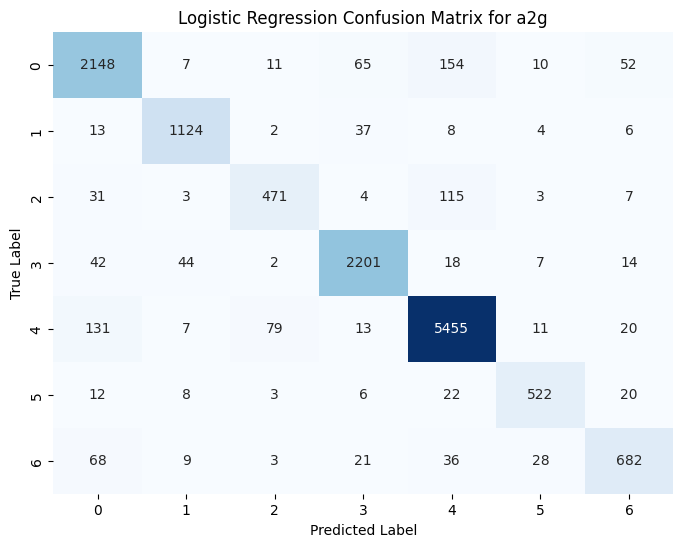

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# using dataset a2g

# splitting the data into X and Y  
X_a2g = np.array(a2g['image_flat'].tolist())
y_a2g = np.array(a2g['label'])

# splitting the data into test and train sets
X_train_a2g, X_test_a2g, y_train_a2g, y_test_a2g = train_test_split(X_a2g, y_a2g, test_size=0.2, random_state=42)

# train logistic regression model on a2g
logistic_regression_a2g = LogisticRegression(max_iter=250) 
logistic_regression_a2g.fit(X_train_a2g, y_train_a2g)

# evaluating the logistic regression model on the test set for a2g
y_pred_a2g = logistic_regression_a2g.predict(X_test_a2g)
accuracy_a2g = accuracy_score(y_test_a2g, y_pred_a2g)
conf_matrix_a2g = confusion_matrix(y_test_a2g, y_pred_a2g)

# confusion matrix for a2g
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_a2g, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression Confusion Matrix for a2g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Random Forest

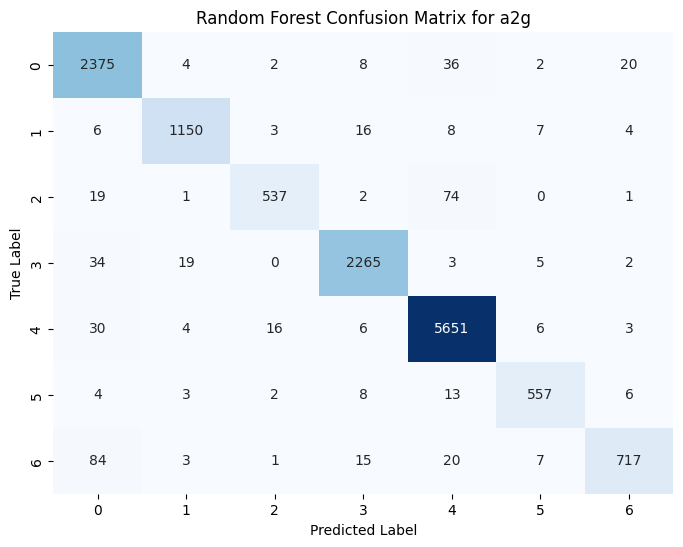

In [49]:
# splitting the data into X and Y  
X_a2g = np.array(a2g['image_flat'].tolist())
y_a2g = np.array(a2g['label'])

# splitting the data into test and train sets
X_train_a2g, X_test_a2g, y_train_a2g, y_test_a2g = train_test_split(X_a2g, y_a2g, test_size=0.2, random_state=42)

# train random forest model on a2g
random_forest_a2g = RandomForestClassifier()
random_forest_a2g.fit(X_train_a2g, y_train_a2g)

# evaluating the random forest model on the test set for a2g
y_pred_a2g_rf = random_forest_a2g.predict(X_test_a2g)
accuracy_a2g_rf = accuracy_score(y_test_a2g, y_pred_a2g_rf)
conf_matrix_a2g_rf = confusion_matrix(y_test_a2g, y_pred_a2g_rf)

# confusion matrix for a2g
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_a2g_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix for a2g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Cross-Validation on Both Models

In [53]:
from sklearn.model_selection import cross_val_score

# logistic regression cross-validation
logistic_regression_cv_scores = cross_val_score(
    logistic_regression_a2g, X_a2g, y_a2g, cv=5, scoring='accuracy'
)
display(Markdown(f'**Logistic Regression CV Accuracy:** {logistic_regression_cv_scores.mean():.2f} ± {logistic_regression_cv_scores.std():.2f}'))

# random forest cross-validation
random_forest_cv_scores = cross_val_score(
    random_forest_a2g, X_a2g, y_a2g, cv=5, scoring='accuracy'
)
display(Markdown(f'**Random Forest CV Accuracy:** {random_forest_cv_scores.mean():.2f} ± {random_forest_cv_scores.std():.2f}'))

/Users/nya/datasci_223/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nya/datasci_223/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

**Logistic Regression CV Accuracy:** 0.92 ± 0.00

**Random Forest CV Accuracy:** 0.96 ± 0.00

## Part 2: Model showdown: upper vs lowercase on abcXYZ

In [54]:
# using dataset abcxyz

# splitting the data into X and Y  
X_abcxyz = np.array(abcxyz['image_flat'].tolist())
y_abcxyz = np.array(abcxyz['label'])

# splitting the data into train and validation  sets
X_train_abcxyz, X_val_abcxyz, y_train_abcxyz, y_val_abcxyz = train_test_split(X_abcxyz, y_abcxyz, test_size=0.2, random_state=42)

In [57]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

model = RandomForestClassifier(random_state=42)

# setting parameters
param_grid = {
    'n_estimators': [10, 50, 100],  
    'max_depth': [None, 5, 10],     
}

# using gridsearchCV with a 5-fold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# fitting with train set
grid_search.fit(X_train_abcxyz, y_train_abcxyz)
print("Best parameters:", grid_search.best_params_)

# identifying the best model
best_model = grid_search.best_estimator_

# calculating the accuracy on the validation set
validation_accuracy = best_model.score(X_val_abcxyz, y_val_abcxyz)
print(f'Validation Set Accuracy: {validation_accuracy}')

# combinng the training and validation sets
X_combined = np.vstack((X_train_abcxyz, X_val_abcxyz))
y_combined = np.concatenate((y_train_abcxyz, y_val_abcxyz))

# fitting the combined dataset to find the best model
best_model.fit(X_combined, y_combined)

179667.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179667.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179667.40s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179667.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179667.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179667.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179667.43s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179667.43s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179667.43s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179667.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179667.45s - pydevd: Sending m

Best parameters: {'max_depth': None, 'n_estimators': 100}
Validation Set Accuracy: 0.8388442287274382


RandomForestClassifier(random_state=42)